# 监督学习 - 双相障碍检测
<br>
<hr>

# 1. 实验介绍

## 1.1 实验背景

双相障碍属于心境障碍的一种疾病，英文名称为 Bipolar Disorder（BD），别名为 Bipolar Affective Disorder，表示既有躁狂发作又有抑郁发作的一类疾病。

目前病因未明，主要是生物、心理与社会环境诸多方面因素参与其发病过程。

当前研究发现，在双相障碍发生过程中遗传因素、环境或应激因素之间的交互作用、以及交互作用的出现时间点等都产生重要的影响；临床表现按照发作特点可以分为抑郁发作、躁狂发作或混合发作。

双相障碍检测，即通过医学检测数据预测病人是否双相障碍，或双相障碍治疗是否有效。

医学数据包括医学影像数据与肠道数据。

由于缺少医学样本且特征过多，因此选取合适的特征对双模态特征进行整合并训练合适的分类器进行模型预测具有较强的现实需求与医学意义。

本实验需要大家完成少样本、多特征下的监督学习。

## 1.2 实验要求

a) 实现双模态特征选择与提取整合。

b) 选择并训练机器学习模型进行准确分类。

c) 分析不同超参数以及特征选择方法对模型的结果影响。

## 1.3 实验环境

可以使用 Numpy 库进行相关数值运算，使用 sklearn 库进行特征选择和训练机器学习模型等。

## 1.4 注意事项
+ Python 与 Python Package 的使用方式，可在右侧 `API文档` 中查阅。
+ 当右上角的『Python 3』长时间指示为运行中的时候，造成代码无法执行时，可以重新启动 Kernel 解决（左上角『Kernel』-『Restart Kernel』）。

## 1.5 参考资料

Numpy：https://www.numpy.org/

Scikit-learn： https://scikit-learn.org/

# 2.实验内容


## 2.1 导入数据

医疗数据集存放在左侧栏中的 `DataSet.xlsx` 中，共包括 39 个样本和 3 张表，表 `Feature1` 为医学影像特征，表 `Feature2` 为肠道特征，表 `label` 为样本类标。

In [1]:
# 导入相关库
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
from minepy import MINE
from sklearn import svm
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn import naive_bayes
from scipy.stats import pearsonr
from sklearn.manifold import TSNE
from IPython.display import display
from datetime import datetime as dt
from sklearn.externals import joblib
from sklearn.decomposition import PCA
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
%matplotlib inline

/home/jovyan/.virtualenvs/basenv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
#导入医疗数据
data_xls = pd.ExcelFile('DataSet.xlsx')
data={}

#查看数据名称与大小
for name in data_xls.sheet_names:
    df = data_xls.parse(sheet_name=name,header=None)
    print("%-8s 表的 shape:"%name,df.shape)
    data[name] = df
    
#获取 特征1 特征2 类标    
feature1_raw = data['Feature1']
feature2_raw = data['Feature2']
label = data['label']

#显示第一条样本数据
display(feature1_raw.head(n=1))
display(feature2_raw.head(n=1))
display(label.head(n=1))

Feature1 表的 shape: (39, 6670)
Feature2 表的 shape: (39, 377)
label    表的 shape: (39, 1)


,0,1,2,3,4,5,6,7,8,9,...,6660,6661,6662,6663,6664,6665,6666,6667,6668,6669
0,0.816394,0.313184,0.437542,0.421138,0.54941,0.740194,-0.097087,0.005081,0.009196,0.105606,...,0.548366,0.122165,0.289676,0.21173,0.364212,0.163357,0.282966,0.212861,0.417709,0.523209


,0,1,2,3,4,5,6,7,8,9,...,367,368,369,370,371,372,373,374,375,376
0,100.0,0.0,0.0,0.38706,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.07677,0.0,0.0,21.16578,0,0.0


,0
0,1


可以看到，医疗数据中的样本和特征数量存在着极大的不平衡。

其中医疗影像数据共 6670 维，肠道数据共 377 维，而样本仅有 39 个，其中正样本标签为 1 ，负样本标签为 -1 。

因此，特征的筛选和组合以及机器学习模型的选择优化对提高模型的性能极其重要。

## 2.2 准备数据

**数据预处理** 是一种数据挖掘技术，它是指把原始数据转换成可以理解的格式。在这个过程中一般有数据清洗、数据变换、数据组织、数据降维和格式化等操作。

对于本数据集，没有无效或丢失的条目；然而需要我们进行特征的筛选和整合。

我们可以针对某一些特征存在的特性进行一定的调整。

这些预处理可以极大地帮助我们提升机器学习算法模型的性能和预测能力。


**归一化数字特征**

对数值特征施加一些形式的缩放，可以减少量纲对数据的影响。

对数据分析发现，`Feature2` 中的特征值存在较大差异，比如第 0 维和第 374 维；大家可以试试观察其它列特征是否有这种现象？

数据归一化的作用:                     
１）把数据变成 (０,１) 或者（-1,1）之间的小数。主要是为了数据处理方便提出来的，把数据映射到 0～1 范围之内处理，更加便捷快速。                                         
２）把有量纲表达式变成无量纲表达式，便于不同单位或量级的指标能够进行比较和加权。
             
注意：一旦使用了缩放，观察数据的原始形式不再具有它本来的意义了。

我们将使用 [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) 来完成这个任务。

In [3]:
from sklearn.preprocessing import MinMaxScaler


def processing_data(data_path):
    """
    数据处理
    :param data_path: 数据集路径
    :return: feature1,feature2,label: 处理后的特征数据、标签数据
    """
    
    #导入医疗数据
    data_xls = pd.ExcelFile(data_path)
    data={}
    
    #查看数据名称与大小
    for name in data_xls.sheet_names:
            df = data_xls.parse(sheet_name=name,header=None)
            data[name] = df
    
    #获取 特征1 特征2 类标    
    feature1_raw = data['Feature1']
    feature2_raw = data['Feature2']
    label = data['label']


    # 初始化一个 scaler，并将它施加到特征上
    scaler = MinMaxScaler()
    feature1 = pd.DataFrame(scaler.fit_transform(feature1_raw))
    feature2 = pd.DataFrame(scaler.fit_transform(feature2_raw))

    return feature1,feature2,label

In [4]:
#数据路径
data_path = "DataSet.xlsx"

#获取处理后的特征数据和类标数据
feature1,feature2,label = processing_data(data_path)

# 显示一个经过缩放的样例记录
display(feature1.head(n = 1))
display(feature2.head(n = 1))

,0,1,2,3,4,5,6,7,8,9,...,6660,6661,6662,6663,6664,6665,6666,6667,6668,6669
0,0.811348,0.0,0.414645,0.201443,0.35027,0.662461,0.289633,0.372597,0.316459,0.49556,...,0.855183,0.670516,0.813051,0.594934,0.757542,0.567247,0.632496,0.578548,0.732079,0.857594


,0,1,2,3,4,5,6,7,8,9,...,367,368,369,370,371,372,373,374,375,376
0,0.998685,0.0,0.0,0.12642,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.019504,0.0,0.0,0.771442,0.0,0.0


## 2.3 评价模型性能

我们的研究目的，是通过医学检测数据预测病人是否双相障碍，或双相障碍治疗是否有效。                           
因此，对于准确预测病人是否双相障碍，或双相障碍治疗是否有效是问题的关键。                           
这样看起来使用**准确率**作为评价模型的标准是合适的。                

我们将算法预测结果分为四种情况：

<center><img src="https://imgbed.momodel.cn/20200819172058.png" width=600/><center>
    
<br>
    
**准确率（Accuracy）**是指分类正确的样本占总样本个数的比例
$$accuracy = \frac{预测正确的样本数}{总样本数} = \frac{TP+TN}{TP+TN+FP+FN}$$
    
但是，把双相障碍的病人预测为正常人，或者把治疗无效预测为有效是存在极大的医学隐患的。        
我们期望的模型具有能够 **查全** 所有双相障碍病人或者双相治疗有效法人病例与模型的准确预测**同样重要**。               
因此，我们使用 **查全率（Recall）** 作为评价模型的另一标准。
    
**查准率（Precision）**在算法预测都为正类（Positive）样本中，实际是正类（Positive）样本的比例
$$precision = \frac{TP}{TP+FP}$$ 
    
**查全率（Recall）** 在实际值是正类（Positive）的样本中，算法预测是正类样本的比例
$$recall=\frac{TP}{TP+FN}$$
我们使用 **F-beta score** 作为评价指标，这样能够同时考虑查准率和查全率：

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

当 $\beta = 1$ 时，就是我们常听说的 **F1 值（F1 score）**                
当 $\beta = 0.5$ 的时候更多的强调查准率，这叫做 **F$_{0.5}$ score** （或者为了简单叫做 F-score）

## 2.4 特征选择

使用监督学习算法的一个重要的任务是决定哪些数据特征能够提供最强的预测能力。                     
专注于少量的有效特征和标签之间的关系，我们能够更加简单具体地理解标签与特征之间的关系，这在很多情况下都是十分有用的。

可以看到：医疗数据中的样本和特征数量存在着极大的不平衡，其中医疗影像数据共 6670 维，肠道数据共 377 维，而样本仅有 39 个。

因此，为了训练预测模型，特征的筛选和组合以及机器学习模型的选择优化极其重要。

同时，在这个项目的情境下选择一小部分特征，也具有很大的医学意义。



### 2.4.1 常见的特征选择方法

In [ ]:
# 对 feature1 和 feature2 进行整合
features = pd.concat([feature1,feature2],axis=1)

（1）**feature_importance 排序**

选择一个有 `feature_importance_` 属性的机器学习分类器（例如决策树、AdaBoost、随机森林）或者 sklearn 中的统计函数对特征进行计算筛选。

In [1]:
# 导入一个有 feature_importances_ 的监督学习模型
from sklearn import tree
clf = tree.DecisionTreeClassifier(random_state=42)
clf.fit(features,label)

# 提取特征重要性
importances = clf.feature_importances_

# 需要提取的特征
# 定义特征数量并根据重要性排序 获得特征序号
select_feature_number = 5
select_features = (np.argsort(importances)[::-1])[:select_feature_number]

# 查看提取的特征序号
print(select_features)

NameError: name 'features' is not defined

（2）**相关性系数选择**

使用 `sklearn` 中的统计函数对特征进行计算筛选

In [ ]:
# 导入需要的库
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from scipy.stats import pearsonr
from minepy import MINE

计算各个特征与标签的相关系数，常用的指标就是皮尔逊相关系数

In [ ]:
# 统计特征值和 label 的皮尔孙相关系数  进行排序筛选特征
select_feature_number = 10
select_features = SelectKBest(lambda X, Y: tuple(map(tuple,np.array(list(map(lambda x:pearsonr(x, Y), X.T))).T)), 
                              k=select_feature_number
                             ).fit(features, np.array(label).flatten()).get_support(indices=True)

# 查看提取的特征序号
print(select_features)

（3）**卡方检验**

卡方检验就是统计样本的实际观测值与理论推断值之间的偏离程度。                       
实际观测值与理论推断值之间的偏离程度就决定卡方值的大小；                
如果卡方值越大，二者偏差程度越大；反之，二者偏差越小；若两个值完全相等时，卡方值就为0，表明理论值完全符合。                      


In [ ]:
# 卡方检验 筛选特征
select_feature_number = 10
select_features = SelectKBest(chi2, 
                              k=select_feature_number
                             ).fit(features, np.array(label).flatten()).get_support(indices=True)

# 查看提取的特征序号
print(select_features)

（4）**互信息法**

互信息法也是用来评定类别自变量对类别因变量的相关性的。

In [ ]:
# 互信息法 筛选特征
# 由于 MINE 的设计不是函数式的，定义 mic 方法将其为函数式的，返回一个二元组，二元组的第 2 项设置成固定的 P 值 0.5
def mic(x, y):
      m = MINE()
      m.compute_score(x, y)
      return (m.mic(), 0.5)

select_feature_number = 5  
select_features = SelectKBest(lambda X, Y: tuple(map(tuple,np.array(list(map(lambda x:mic(x, Y), X.T))).T)), 
                              k=select_feature_number
                             ).fit(features, np.array(label).flatten()).get_support(indices=True)

# 查看提取的特征序号
print(select_features)

（5）**特征降维之 t-SNE**

所谓的降维就是指采用某种映射方法，将原高维空间中的数据点映射到低维度的空间中去。                  
由于数据降维是函数映射，因此，不同于特征筛选，特征降维会改变的特征值，会丢失一定的特征信息。                   
但这也有助于我们对特征进行低维观察和可视化，以选择进一步的筛选操作。                        

In [ ]:
# 导入需要的库
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

TSNE 是由 T 和 SNE 组成，也就是 T 分布和随机近邻嵌入（Stochastic neighbour Embedding ），简单来说，TSNE 就是一种数据可视化的工具，能够将高维数据降到 2-3 维，然后将特征值绘制在平面图或者三维空间上，便于观察数据分布情况。

In [ ]:
# 选择降维维度
tsne = TSNE(n_components=2)
feature_tsne = tsne.fit_transform(features)

# 可视化类标中不能出现负值
tsne_label = np.array(label).flatten()

# 可视化
plt.scatter(feature_tsne[:, 0], feature_tsne[:, 1], c=tsne_label)
plt.show()


（6）**特征降维之主成分分析算法 PCA**

Principal Component Analysis(PCA) 是最常用的线性降维方法，它的目标是通过某种线性投影，将高维的数据映射到低维的空间中表示，并期望在所投影的维度上数据的方差最大，以此使用较少的数据维度，同时保留住较多的原数据的特性。

In [ ]:
# 选择降维维度
pca = PCA(n_components=2)
feature_pca = pca.fit_transform(features)

# 可视化标签中不能出现负值
pca_label = np.array(label).flatten()

# 可视化
plt.scatter(feature_pca[:, 0], feature_pca[:, 1], c=pca_label)
plt.show()

（7）**双模态特征选择和融合**

以上特征选择都是在将医疗影像数据和肠道数据直接拼接后进行的。         
但是事实上，双模态特征各自具有不同的分布和医学意义，因此，分别对各特征进行筛选，再按照相关算法进行特征的融合是比较合理的方法。

In [7]:
# 统计特征值和label的皮尔孙相关系数  对两类特征分别进行排序筛选特征
select_feature_number = 5
select_feature1 = SelectKBest(lambda X, Y: tuple(map(tuple,np.array(list(map(lambda x:pearsonr(x, Y), X.T))).T)), 
                              k=select_feature_number
                             ).fit(feature1, np.array(label).flatten()).get_support(indices=True)

select_feature2 = SelectKBest(lambda X, Y: tuple(map(tuple,np.array(list(map(lambda x:pearsonr(x, Y), X.T))).T)), 
                              k=select_feature_number
                             ).fit(feature2, np.array(label).flatten()).get_support(indices=True)

# 查看排序后特征
print("select feature1 name:", select_feature1)
print("select feature2 name:", select_feature2)

# 双模态特征选择并融合
new_features = pd.concat([feature1[feature1.columns.values[select_feature1]],
                          feature2[feature2.columns.values[select_feature2]]],axis=1)
print("new_features shape:",new_features.shape)
# print("new feature:", new_features)

select feature1 name: [1242 2060 2064 3290 3912]
select feature2 name: [ 30  56  77 134 247]
new_features shape: (39, 10)
new feature:         1242      2060      2064      3290      3912      30        56    \
0   0.485120  0.791782  0.636598  0.736082  0.714859  0.000000  0.000000   
1   0.538347  0.691736  0.936194  0.554668  0.904123  0.000000  0.000000   
2   0.577353  0.836702  0.751379  0.749428  0.789394  0.000000  0.000000   
3   0.886068  1.000000  0.879182  0.977530  0.906589  0.000000  0.000000   
4   0.359287  0.548250  0.607674  0.728504  0.265145  0.000000  0.000000   
5   0.254868  0.849786  0.693657  0.450962  0.694317  0.000000  0.000000   
6   1.000000  0.957640  0.914794  0.925708  0.790024  0.000000  0.000000   
7   0.563647  0.837080  0.853095  0.740983  0.862940  0.000000  0.000000   
8   0.485647  0.562818  0.674462  0.743994  0.762817  0.000000  0.000000   
9   0.994406  0.938872  1.000000  0.881409  0.948843  0.460018  0.000000   
10  0.860102  0.908292  0.920

### 2.4.2 进行特征选择

定义 `feature_select` 函数进行特征选择

以皮尔逊相关系数为例，进行特征选择并得到新特征数据

In [ ]:
def feature_select(feature1, feature2, label):
    """
    特征选择
    :param  feature1,feature2,label: 数据处理后的输入特征数据、标签数据
    :return: new_features,label:特征选择后的特征数据、标签数据
    """

    # 整合特征
    features = pd.concat([feature1, feature2], axis=1)

    # 统计特征值和label的皮尔孙相关系数  进行排序筛选特征
    select_feature_number = 12
    select_features = SelectKBest(lambda X, Y: tuple(map(tuple, np.array(list(map(lambda x: pearsonr(x, Y), X.T))).T)),
                                  k=select_feature_number).fit(features,np.array(label).flatten()).get_support(indices=True)

    # 查看提取的特征序号
    print("查看提取的特征序号:", select_features)

    # 特征选择
    new_features = features[features.columns.values[select_features]]

    # 返回筛选后的数据
    return new_features, label

In [ ]:
#查看特征选择结果
new_features,label=feature_select(feature1, feature2, label)
print("特征 shape: ", new_features.shape)

### 2.4.3 混洗和切分数据

现在特征选择已经完成并得到了新的特征数据。                                         
那么下面将数据（包括特征和它们的标签）整合并切分成训练集和测试集。                             
其中 80% 的数据将用于训练和 20% 的数据用于测试。                      
然后再进一步把训练数据分为训练集和验证集，用来选择和优化模型。                                     

In [8]:
from sklearn.model_selection import train_test_split


def data_split(features, label):
    """
    数据切分
    :param features: 特征选择后的输入特征数据
    :param label: 标签数据
    :return: X_train:数据切分后的训练数据
             X_val:数据切分后的验证数据
             X_test:数据切分后的测试数据
             y_train:数据切分后的训练数据标签
             y_val:数据切分后的验证数据标签
             y_test:数据切分后的测试数据标签
    """
    # 将 features 和 label 数据切分成训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=0, stratify=label)

    # 将 X_train 和 y_train 进一步切分为训练集和验证集
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [9]:
# 进行数据切分
X_train, X_val, X_test, y_train, y_val, y_test = data_split(new_features, label)

# 显示切分的结果
print("Training set has {} samples.".format(X_train.shape[0]))
print("Validation set has {} samples.".format(X_val.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 24 samples.
Validation set has 7 samples.
Testing set has 8 samples.


## 2.5 监督学习模型

 [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) 中的监督学习模型包括：
- 高斯朴素贝叶斯 (GaussianNB)
- 决策树 (DecisionTree)
- 集成方法 (Bagging、 AdaBoost、 Random Forest、 Gradient Boosting)
- K 近邻 (K Nearest Neighbors)
- 随机梯度下降分类器 (SGDC)
- 支持向量机 (SVM)
- Logistic 回归（LogisticRegression）



从监督学习模型中选择适合我们这个问题的模型。

为了正确评估你选择的每一个模型的性能，创建一个能够帮助你快速有效地使用训练集并在验证集上做预测的训练和验证的流水线是十分重要的。

 - 从[`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics)中导入`accuracy_score`，`recall_score`和`fbeta_score`。
 - 用训练集拟合学习器，并记录训练时间。
 - 对训练集和验证集进行预测并记录预测时间。
 - 计算预测训练集的准确率，召回率和 F-score。
 - 计算预测验证集的准确率，召回率和 F-score。

In [10]:
# 从sklearn中导入评价指标 - fbeta_score，accuracy_score，recall_score
from sklearn.metrics import fbeta_score, accuracy_score, recall_score


def train_predict(learner, X_train, y_train, X_val, y_val):
    '''
    模型训练验证
    :param learner: 监督学习模型
    :param X_train: 训练集 特征数据
    :param y_train: 训练集 类标
    :param X_val: 验证集 特征数据
    :param y_val: 验证集 类标
    :return: results: 训练与验证结果
    '''

    results = {}

    # 使用训练集数据来拟合学习器
    start = time()  # 获得程序开始时间
    learner = learner.fit(X_train, y_train)
    end = time()  # 获得程序结束时间

    # 计算训练时间
    # results['train_time'] = end - start

    # 得到在验证集上的预测值
    start = time()  # 获得程序开始时间
    predictions_val = learner.predict(X_val)
    predictions_train = learner.predict(X_train)
    end = time()  # 获得程序结束时间

    # 计算预测用时
    # results['pred_time'] = end - start

    # 计算在训练数据的准确率
    results['acc_train'] = round(accuracy_score(y_train, predictions_train),4)

    # 计算在验证上的准确率
    results['acc_val'] = round(accuracy_score(y_val, predictions_val),4)

    # 计算在训练数据上的召回率
    results['recall_train'] = round(recall_score(y_train, predictions_train),4)

    # 计算验证集上的召回率
    results['recall_val'] = round(recall_score(y_val, predictions_val),4)

    # 计算在训练数据上的F-score
    results['f_train'] = round(fbeta_score(y_train, predictions_train, beta=1),4)

    # 计算验证集上的F-score
    results['f_val'] = round(fbeta_score(y_val, predictions_val, beta=1),4)

    # 成功
    print("{} trained on {} samples.".format(learner.__class__.__name__, len(X_val)))

    # 返回结果
    return results

在下面的代码单元将实现以下功能：             
- 导入三个监督学习模型。             
- 初始化三个模型并存储在`'clf_A'`，`'clf_B'`和`'clf_C'`中。
  - 使用模型的默认参数值，在接下来的部分中将需要对某一个模型的参数进行调整。             
  - 设置`random_state`  (如果有这个参数)。       

In [17]:
# 从sklearn中导入三个监督学习模型
from sklearn import tree
from sklearn import naive_bayes
from sklearn import svm
from time import time

# 初始化三个模型
clf_A = tree.DecisionTreeClassifier(random_state=42)
clf_B = naive_bayes.GaussianNB()
clf_C = svm.SVC()


# 收集学习器的结果
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    results[clf_name] = train_predict(clf, X_train, y_train, X_val, y_val)

    
# 打印三个模型得到的训练验证结果
print("高斯朴素贝叶斯模型结果:", results['GaussianNB'])
print("支持向量机模型结果:", results['SVC'])
print("决策树模型结果:", results['DecisionTreeClassifier'])

DecisionTreeClassifier trained on 7 samples.
GaussianNB trained on 7 samples.
SVC trained on 7 samples.
高斯朴素贝叶斯模型结果: {'acc_train': 0.7917, 'acc_val': 0.5714, 'recall_train': 0.5455, 'recall_val': 0.3333, 'f_train': 0.7059, 'f_val': 0.4}
支持向量机模型结果: {'acc_train': 0.9583, 'acc_val': 0.7143, 'recall_train': 1.0, 'recall_val': 0.3333, 'f_train': 0.9565, 'f_val': 0.5}
决策树模型结果: {'acc_train': 1.0, 'acc_val': 0.7143, 'recall_train': 1.0, 'recall_val': 0.6667, 'f_train': 1.0, 'f_val': 0.6667}


## 2.6 提高效果

我们可以从三个有监督的学习模型中选择 **最好的** 模型。                             
你将在整个训练集（`X_train`和`y_train`）上使用网格搜索优化至少调节一个超参数以获得一个比没有调节之前更好的目标结果。

调节选择的模型的参数。

使用网格搜索（`GridSearchCV`）来至少调整模型的重要参数（至少调整一个），这个参数至少需尝试 3 个不同的值。你要使用整个训练集来完成这个过程。

- 导入 [`sklearn.model_selection.GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)  和  [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) 
- 初始化你选择的分类器，并将其存储在 `clf` 中。
 - 设置 `random_state`  (如果有这个参数)。
- 创建一个对于这个模型你希望调整参数的字典。
 - 例如:  parameters = {'parameter' : [list of values]}。
 - **注意：** 如果你的学习器有 `max_features` 参数，请不要调节它！
- 使用 `make_scorer` 来创建一个 `fbeta_score` 评分对象（设置 $\beta = 1$）。
- 在分类器 clf 上用 `scorer` 作为评价函数运行网格搜索，并将结果存储在 grid_obj 中。
- 用训练集（X_train, y_train）训练 grid search object ,并将结果存储在 `grid_fit` 中。

由于训练样本少，因此模型会存在较为严重的过拟合现象。

定义函数 `plot_learning_curve` 绘制学习曲线以观察训练过程中的过拟合现象。

In [12]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, X, y, cv=None, n_jobs=1):
    """
    绘制学习曲线
    :param estimator: 训练好的模型
    :param X:绘制图像的 X 轴数据
    :param y:绘制图像的 y 轴数据
    :param cv: 交叉验证
    :param n_jobs:
    :return:
    """
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure('Learning Curve', facecolor='lightgray')
    plt.title('Learning Curve')
    plt.xlabel('train size')
    plt.ylabel('score')
    plt.grid(linestyle=":")
    plt.plot(train_sizes, train_scores_mean, label='traning score')
    plt.plot(train_sizes, test_scores_mean, label='val score')
    plt.legend()
    plt.show()

In [13]:
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.metrics import make_scorer

def search_model(X_train, y_train,X_val,y_val, model_save_path):
    """
    创建、训练、优化和保存深度学习模型
    :param X_train, y_train: 训练集数据
    :param X_val,y_val: 验证集数据
    :param save_model_path: 保存模型的路径和名称
    """

    #创建监督学习模型 以决策树为例
    clf = tree.DecisionTreeClassifier(random_state=42)

    # 创建调节的参数列表
    parameters = {'max_depth': range(5,10),
                  'min_samples_split': range(2,10)}

    # 创建一个fbeta_score打分对象 以F-score为例
    scorer = make_scorer(fbeta_score, beta=1)

    # 在分类器上使用网格搜索，使用'scorer'作为评价函数
    kfold = KFold(n_splits=10) #切割成十份

    # 同时传入交叉验证函数
    grid_obj = GridSearchCV(clf, parameters, scorer, cv=kfold)

    #绘制学习曲线
    plot_learning_curve(clf, X_train, y_train, cv=kfold, n_jobs=4)

    # 用训练数据拟合网格搜索对象并找到最佳参数
    grid_obj.fit(X_train, y_train)

    # 得到estimator并保存
    best_clf = grid_obj.best_estimator_
    joblib.dump(best_clf, model_save_path)

    # 使用没有调优的模型做预测
    predictions = (clf.fit(X_train, y_train)).predict(X_val)
    best_predictions = best_clf.predict(X_val)

    # 调优后的模型
    print ("best_clf\n------")
    print (best_clf)

    # 汇报调参前和调参后的分数
    print("\nUnoptimized model\n------")
    print("Accuracy score on validation data: {:.4f}".format(accuracy_score(y_val, predictions)))
    print("Recall score on validation data: {:.4f}".format(recall_score(y_val, predictions)))
    print("F-score on validation data: {:.4f}".format(fbeta_score(y_val, predictions, beta = 1)))
    print("\nOptimized Model\n------")
    print("Final accuracy score on the validation data: {:.4f}".format(accuracy_score(y_val, best_predictions)))
    print("Recall score on validation data: {:.4f}".format(recall_score(y_val, best_predictions)))
    print("Final F-score on the validation data: {:.4f}".format(fbeta_score(y_val, best_predictions, beta = 1)))



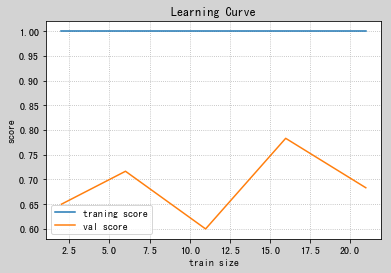

best_clf
------
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

Unoptimized model
------
Accuracy score on validation data: 0.7143
Recall score on validation data: 0.6667
F-score on validation data: 0.6667

Optimized Model
------
Final accuracy score on the validation data: 0.7143
Recall score on validation data: 0.6667
Final F-score on the validation data: 0.6667


In [14]:
#训练，优化模型并保存
search_model(X_train, y_train,X_val,y_val, model_save_path='./results/my_model.m')

可以看出优化后的模型，比没有优化的模型好。但是也应该关注模型过拟合的现象问题。

对测试数据进行预测，观察模型的性能

In [2]:
def load_and_model_prediction(X_test,y_test,model_path):
    """
    加载模型和评估模型
    :param X_test,y_test: 测试集数据
    :param save_model_path: 加载模型的路径和名称,请填写你认为最好的模型
    :return:
    """
    #加载模型
    my_model=joblib.load(model_path)

    #对测试数据进行预测
    copy_test = [value for value in X_test]
    copy_predicts = my_model.predict(X_test)

    print ("Accuracy on test data: {:.4f}".format(accuracy_score(y_test, copy_predicts)))
    print ("Recall on test data: {:.4f}".format(recall_score(y_test, copy_predicts)))
    print ("F-score on test data: {:.4f}".format(fbeta_score(y_test, copy_predicts, beta = 1)))

In [16]:
#加载模型并对测试样本进行测试
model_path="./results/my_model.m"
load_and_model_prediction(X_test,y_test,model_path)

Accuracy on test data: 0.8750
Recall on test data: 0.6667
F-score on test data: 0.8000


# 3. 测试提交

通过对以上步骤流程的了解，相信大家对监督学习有了一定的认识。                       
但是特征选方法比较简单，模型优化也缺少策略，模型指标准确率、召回率、`F-score` 也不高，模型也存在过拟合等机器学习问题。               
大家可以试着写自己的特征选择方法和训练优化自己的监督学习模型，并将其调到最佳状态。                

在训练模型等过程中如果需要**保存数据、模型**等请写到  **results**  文件夹。

## 3.1 训练机器学习模型

监督学习模型训练流程, 包含数据处理、特征选择、训练优化模型、模型保存、评价模型等。  
如果对训练出来的模型不满意, 你可以通过修改数据处理方法、特征选择方法、调整模型类型和参数等方法重新训练模型, 直至训练出你满意的模型。  
如果你对自己训练出来的模型非常满意, 则可以测试提交!  


In [ ]:
def processing_data(data_path):
   
    """
    数据处理
    :param data_path: 数据集路径
    :return: feature1,feature2,label:处理后的特征数据、标签数据
    """
    feature1,feature2,label = None, None, None
    # -------------------------- 实现数据处理部分代码 ----------------------------

    # ------------------------------------------------------------------------
    
    return feature1,feature2,label


def feature_select(feature1, feature2, label): 
    """
    特征选择
    :param  feature1,feature2,label: 数据处理后的输入特征数据，标签数据
    :return: new_features,label:特征选择后的特征数据、标签数据
    """ 
    new_features= None
    # -------------------------- 实现特征选择部分代码 ----------------------------

    # ------------------------------------------------------------------------
    # 返回筛选后的数据
    return new_features,label

def data_split(features,labels):

    """
    数据切分
    :param  features,label: 特征选择后的输入特征数据、类标数据
    :return: X_train, X_val, X_test,y_train, y_val, y_test:数据切分后的训练数据、验证数据、测试数据
    """ 
    
    X_train, X_val, X_test,y_train, y_val, y_test=None, None,None, None, None, None
    # -------------------------- 实现数据切分部分代码 ----------------------------

    # ------------------------------------------------------------------------

    return X_train, X_val, X_test,y_train, y_val, y_test


def search_model(X_train, y_train,X_val,y_val, model_save_path):
    """
    创建、训练、优化和保存深度学习模型
    :param X_train, y_train: 训练集数据
    :param X_val,y_val: 验证集数据
    :param save_model_path: 保存模型的路径和名称
    :return:
    """
    # --------------------- 实现模型创建、训练、优化和保存等部分的代码 ---------------------

    # 保存模型（请写好保存模型的路径及名称）
    # -------------------------------------------------------------------------

    
def load_and_model_prediction(X_test,y_test,save_model_path):
    """
    加载模型和评估模型
    可以实现，比如: 模型优化过程中的参数选择，测试集数据的准确率、召回率、F-score 等评价指标！
    主要步骤:
        1.加载模型(请填写你训练好的最佳模型),
        2.对自己训练的模型进行评估

    :param X_test,y_test: 测试集数据
    :param save_model_path: 加载模型的路径和名称,请填写你认为最好的模型
    :return:
    """
    # ----------------------- 实现模型加载和评估等部分的代码 -----------------------

    # ---------------------------------------------------------------------------



def main():
    """
    监督学习模型训练流程, 包含数据处理、特征选择、训练优化模型、模型保存、评价模型等。  
    如果对训练出来的模型不满意, 你可以通过修改数据处理方法、特征选择方法、调整模型类型和参数等方法重新训练模型, 直至训练出你满意的模型。  
    如果你对自己训练出来的模型非常满意, 则可以进行测试提交! 
    :return:
    """
    data_path = ""  # 数据集路径
    
    save_model_path = ''  # 保存模型路径和名称

    # 获取数据 预处理
    feature1,feature2,label = processing_data(data_path)
   
    #特征选择
    new_features,label = feature_select(feature1, feature2, label)
   
    #数据划分
    X_train, X_val, X_test,y_train, y_val, y_test = data_split(new_features,label)
    
    # 创建、训练和保存模型
    search_model(X_train, y_train,X_val,y_val, save_model_path)

    # 评估模型
    load_and_model_prediction(X_test,y_test,save_model_path)


if __name__ == '__main__':
    main()

## 3.2 数据处理和特征选择

1. 请将你的 `数据处理` 和 `特征选择` 函数进行修改后整合成一个函数 `data_processing_and_feature_selecting()` ，能够对后台的测试数据进行处理和特征选择以便对你的模型进行测试打分。
2. 测试数据的格式与你所使用的医疗数据相同，`xlsx`文件，包括多个测试样本， 3 张表，表 `Feature1` 为医学影像特征共 6670 维，表 `Feature2` 为肠道特征共 377 维，表 `label` 为样本类标，正样本为 1 ，负样本为 -1 。
3. 在修改 `data_processing_and_feature_selecting()` 函数时请务必注意，直接使用你在平台提供的医疗数据集上的特征排序结果对测试数据进行选择即可，避免对测试数据的二次排序结果和原排序结果不同导致测试结果的偏差。
4. 请填写你的模型路径及名称并补充 `predict()` 函数以实现预测。
5. 点击左侧栏`提交结果`后点击`生成文件`则需勾选 `data_processing_and_feature_selecting()` 函数和`predict()`函数的 cell，即【**数据处理和特征选择**】和【**数据预测代**】码答题区域的 cell。
6. 请导入必要的包和第三方库 (包括此文件中曾经导入过的)。
7. 请加载你认为训练最佳的模型，即请按要求填写模型路径。          
8. **测试提交时服务端会调用`data_processing_and_feature_selecting()` 函数和 `predict()` 函数，请不要修改该函数的输入输出及其数据类型。**                                  
9. 测试提交时记得填写你的模型路径及名称, 如果采用 [离线任务](https://momodel.cn/docs/#/zh-cn/%E5%9C%A8GPU%E6%88%96CPU%E8%B5%84%E6%BA%90%E4%B8%8A%E8%AE%AD%E7%BB%83%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0%E6%A8%A1%E5%9E%8B) 请将模型保存在 **results** 文件夹下。

============================  **模型预测代码答题区域**  ============================
<br>


在下方的代码块中编写 **模型预测** 部分的代码，请勿在别的位置作答

In [ ]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib
from sklearn.preprocessing import MinMaxScaler


def data_processing_and_feature_selecting(data_path): 
    """
    特征选择
    :param  data_path: 数据集路径
    :return: new_features,label: 经过预处理和特征选择后的特征数据、标签数据
    """ 
    new_features,label = None, None
    # -------------------------- 实现数据处理和特征选择部分代码 ----------------------------

    # ------------------------------------------------------------------------
    # 返回筛选后的数据
    return new_features,label


    
# -------------------------- 请加载您最满意的模型 ---------------------------
# 加载模型(请加载你认为的最佳模型)
# 加载模型,加载请注意 model_path 是相对路径, 与当前文件同级。
# 如果你的模型是在 results 文件夹下的 my_model.m 模型，则 model_path = 'results/my_model.m'
model_path = None

# 加载模型
model = None

# ---------------------------------------------------------------------------

def predict(new_features):
    """
    加载模型和模型预测
    :param  new_features : 测试数据，是 data_processing_and_feature_selecting 函数的返回值之一。
    :return y_predict : 预测结果是标签值。
    """
    # -------------------------- 实现模型预测部分的代码 ---------------------------
    # 获取输入图片的类别
    y_predict = None

    # -------------------------------------------------------------------------
    
    # 返回图片的类别
    return y_predict

## 3.3 **测试提交函数示例**

例：对数据不做任何预处理，进行特征整合，并训练得到模型`my_model.m`

In [1]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib


def data_processing_and_feature_selecting(data_path): 
    """
    特征选择
    :param  data_path: 数据集路径
    :return: new_features,label: 经过预处理和特征选择后的特征数据、类标数据
    """ 
    
     #导入医疗数据
    data_xls = pd.ExcelFile(data_path)
    data={}
    #查看数据名称与大小
    for name in data_xls.sheet_names:
            df=data_xls.parse(sheetname=name,header=None)
            data[name]=df
    #获取数据
    feature1_raw=data['Feature1']
    feature2_raw=data['Feature2']
    label=data['label']

    # 整合得到新特征
    features = pd.concat([feature1_raw,feature2_raw],axis=1)
    
    new_features = features

    # 返回筛选后的数据
    return new_features,label


    
# -------------------------- 请加载您最满意的模型 ---------------------------
# 加载模型(请加载你认为的最佳模型)
model_path = 'results/my_model.m'

# 加载模型
model = joblib.load(model_path)

# ---------------------------------------------------------------------------

def predict(new_features):
    """
    加载模型和模型预测
    :param  new_features : 测试数据
    :return y_predict : 预测结果
    """

    y_predict = model.predict(new_features)

    
    # 返回图片的类别
    return y_predict

/home/jovyan/.virtualenvs/basenv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# 导入相关库
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
from minepy import MINE
from sklearn import svm
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn import naive_bayes
from scipy.stats import pearsonr
from sklearn.manifold import TSNE
from IPython.display import display
from datetime import datetime as dt
from sklearn.externals import joblib
from sklearn.decomposition import PCA
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')



def data_processing_and_feature_selecting(data_path):
    """
    特征选择
    :param  data_path: 数据集路径
    :return: new_features,label: 经过预处理和特征选择后的特征数据、类标数据
    """
    data_xls = pd.ExcelFile('DataSet.xlsx')
    data = {}
    for name in data_xls.sheet_names:
        df = data_xls.parse(sheet_name=name, header=None)
        # print("%-8s 表的 shape:" % name, df.shape)
        data[name] = df
    feature1_raw = data['Feature1']
    feature2_raw = data['Feature2']
    label = data['label']
    scalar = MinMaxScaler()
    feature1 = pd.DataFrame(scalar.fit_transform(feature1_raw))
    feature2 = pd.DataFrame(scalar.fit_transform(feature2_raw))
    select_feature_number = 5
    select_feature1 = SelectKBest(lambda X, Y: tuple(map(tuple, np.array(list(map(lambda x: pearsonr(x, Y), X.T))).T)),
                                  k=select_feature_number
                                  ).fit(feature1, np.array(label).flatten()).get_support(indices=True)

    select_feature2 = SelectKBest(lambda X, Y: tuple(map(tuple, np.array(list(map(lambda x: pearsonr(x, Y), X.T))).T)),
                                  k=select_feature_number
                                  ).fit(feature2, np.array(label).flatten()).get_support(indices=True)
    new_features = pd.concat([feature1[feature1.columns.values[select_feature1]],
                              feature2[feature2.columns.values[select_feature2]]], axis=1)
    # 返回筛选后的数据
    return new_features, label


model_path = 'results/my_model.m'

# 加载模型
model = joblib.load(model_path)


def predict(new_features):
    """
    加载模型和模型预测
    :param  new_features : 测试数据，是 data_processing_and_feature_selecting 函数的返回值之一。
    :return y_predict : 预测结果是标签值。
    """
    # 获取输入图片的类别
    y_predict = model.predict(new_features)

    # 返回图片的类别
    return y_predict
